## Dissolved Silicon 20 m and below

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}
def use_f_2(x):
    return "%.2f" % x

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [22]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax):
    vmax = 90
    vmin = 0
#    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.Si[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_silicon[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 1), norm=LogNorm());
    fig.colorbar(color, ax=ax)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Si', 'mod_silicon')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Si', 'mod_silicon')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'Si', 'mod_silicon')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Si', 'mod_silicon')
    tspread = spread(temp1[temp1.k >= idepth], 'Si', 'mod_silicon')
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    sc = 4
    ax.arrow(5, 65, 0, 7-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(5, 79, 0, -7+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(9, 65, 0, 7-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(9, 79, 0, -7+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(13, 65, 0, 7-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(13, 79, 0, -7+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(5-1.2, 48, 'bias', rotation=90)
    ax.text(9-1.2, 48, 'systematic', rotation=90)
    ax.text(13-1.2, 42, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Dissolved Si below 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [11]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [12]:
idepth = 19
jdepth = 39

In [13]:
def plot_one_only(year):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle(f'Year {year}')
    pieces2 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces([pieces2])

    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, ax)

    fig.savefig(f'deep_silicon_202111_for_{year}.png')
    
    f = open(f'./deep_silicon_202111_for_{year}_table.tex', 'w')
    f.write(d202111.to_latex(column_format='lccccccccc',
                             formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    
    return d202111

In [33]:
def plot_compare_year(year):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Year {year}')
    pieces1 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    temp1 = read_pieces([pieces1])
    d201905 = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0])

    pieces2 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces([pieces2])
    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1])

    alltogether = pd.concat([d201905, d202111], axis=0)
    fig.savefig(f'deep_silicon_201905_202111_for_{year}.png')
    
    f = open(f'./deep_silicon_201905_202111_for_{year}_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccc', 
                                 formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether

In [32]:
def plot_allyears(lastyear):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Year 2007-{lastyear}')
    pieces1 = []
    for year in range(2007, lastyear+1):
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    temp1 = read_pieces(pieces1)
    d201905 = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0])

    pieces2 = []
    for year in range(2007, lastyear+1):
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces(pieces2)
    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1])

    alltogether = pd.concat([d201905, d202111], axis=0)
    fig.savefig(f'deep_silicon_201905_202111_for_allyears.png')
    
    f = open(f'./deep_silicon_201905_202111_for_allyears_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,1112,-3.0,7.3,0.15,0.044,-0.67,3.0,6.7,-0.49


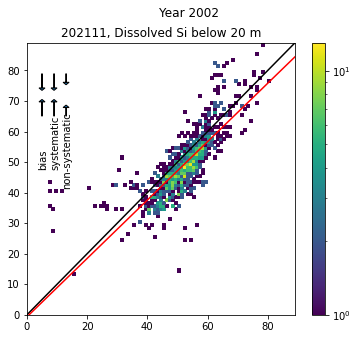

In [34]:
results = plot_one_only(2002)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,850,-1.7,5.1,0.084,0.11,4.1,2.0,4.7,-0.059


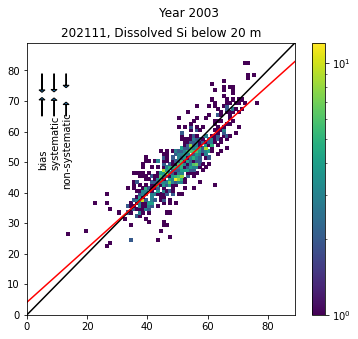

In [35]:
results = plot_one_only(2003)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,843,0.11,5.4,0.083,0.17,8.4,1.6,5.1,0.013


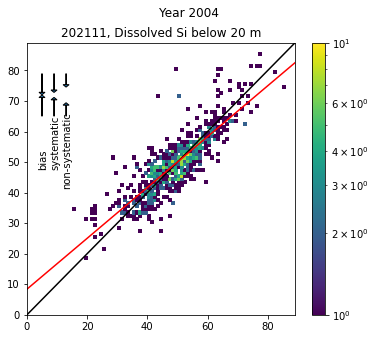

In [36]:
results = plot_one_only(2004)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,812,1.9,6.6,0.12,0.31,1.7e+01,3.8,5.4,0.28


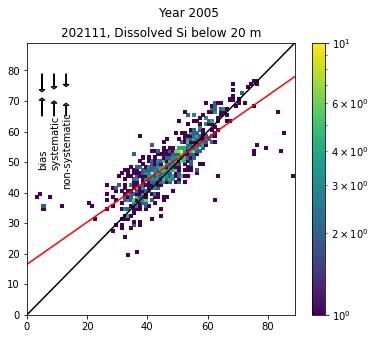

In [37]:
results = plot_one_only(2005)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,723,0.83,6.1,0.12,0.12,6.8,1.4,5.9,-0.22


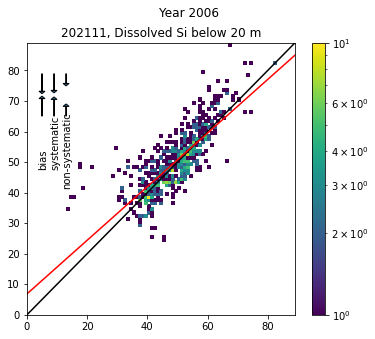

In [27]:
results = plot_one_only(2006)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,827,-4.5,7.4,0.21,0.3,1.1e+01,5.1,5.3,0.091
202111,827,-2.4,5.9,0.14,0.2,7.9,2.9,5.2,-0.045


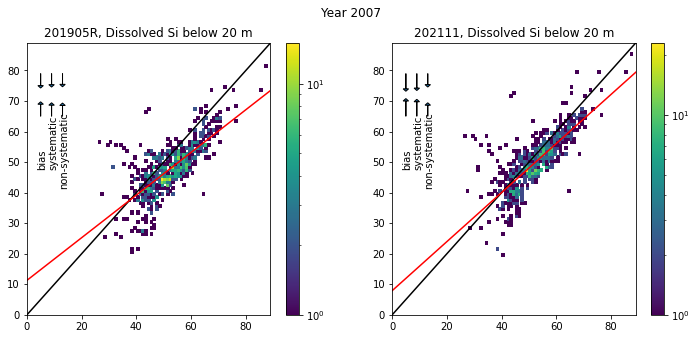

In [38]:
alltogether = plot_compare_year(2007)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,788,-4.8,7.6,0.22,0.26,9.2,5.2,5.5,-0.00074
202111,788,-2.0,5.1,0.11,0.18,7.6,2.5,4.5,0.026


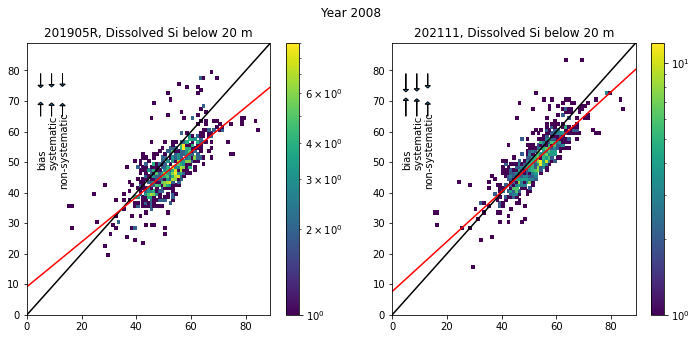

In [39]:
alltogether = plot_compare_year(2008)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,820,-3.0,6.4,0.18,0.31,1.3e+01,3.9,5.0,0.13
202111,820,-1.6,4.9,0.099,0.14,5.6,1.9,4.6,-0.072


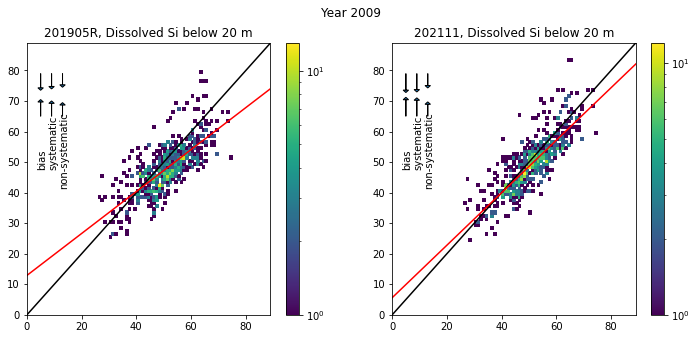

In [40]:
alltogether = plot_compare_year(2009)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1056,-3.3,6.9,0.14,0.37,1.6e+01,5.1,4.6,0.52
202111,1056,-0.89,5.1,0.069,0.2,9.1,2.2,4.6,0.19


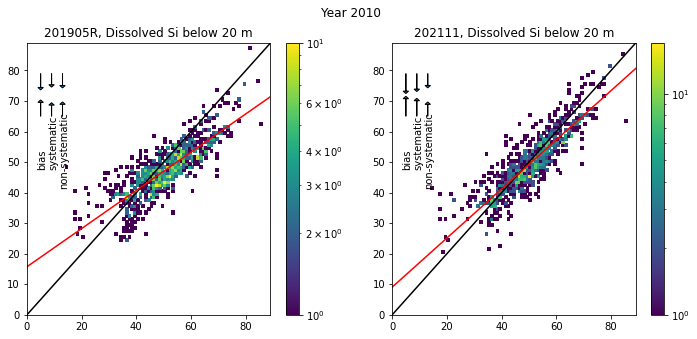

In [41]:
alltogether = plot_compare_year(2010)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,896,-3.0,9.2,0.31,0.64,3e+01,6.9,6.1,0.46
202111,896,-0.26,7.0,0.18,0.44,2.2e+01,4.3,5.5,0.36


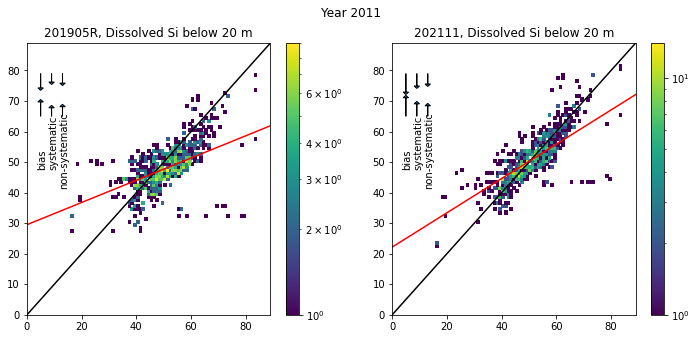

In [42]:
alltogether = plot_compare_year(2011)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,929,-3.0,6.5,0.21,0.42,1.8e+01,4.4,4.8,0.32
202111,929,-1.1,5.5,0.13,0.17,7.8,1.8,5.2,-0.13


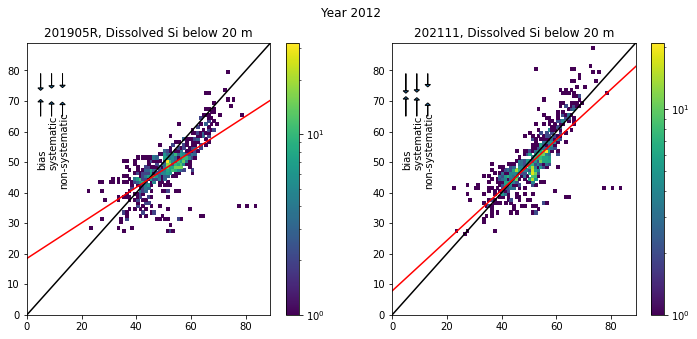

In [43]:
alltogether = plot_compare_year(2012)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,671,-5.4,7.6,0.2,0.15,2.8,5.6,5.2,-0.13
202111,671,-3.5,6.9,0.15,-0.054,-6.4,3.6,5.9,-0.65


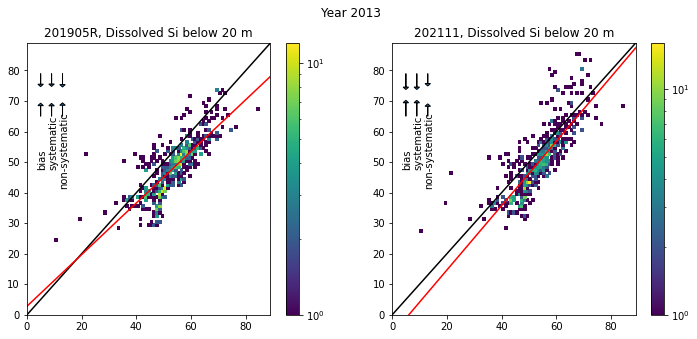

In [45]:
alltogether = plot_compare_year(2013)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1054,-6.1,8.7,0.21,0.4,1.5e+01,7.4,4.6,0.45
202111,1054,-3.3,6.9,0.12,0.24,9.3,4.1,5.5,0.14


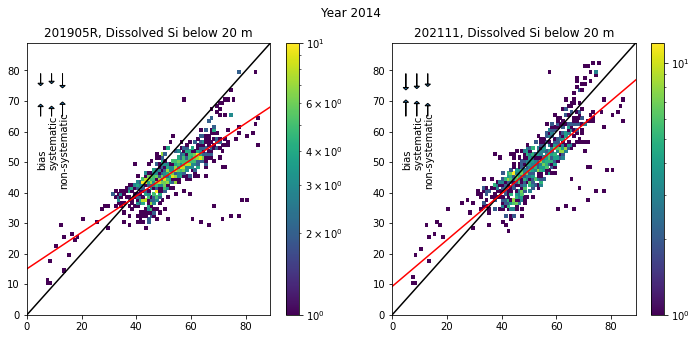

In [54]:
alltogether = plot_compare_year(2014)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,392,-4.8,7.0,0.17,0.35,1.2e+01,5.8,3.9,0.4
202111,392,-2.4,4.9,0.067,0.089,1.9,2.5,4.2,-0.033


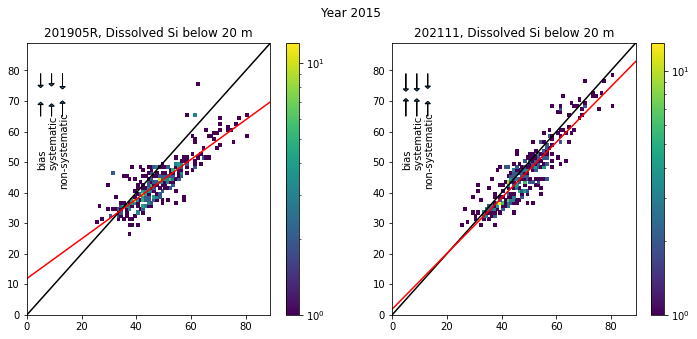

In [57]:
alltogether = plot_compare_year(2015)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,7433,-4.1,7.6,0.2,0.38,1.6e+01,5.4,5.3,0.31
202111,7433,-1.9,5.9,0.11,0.21,9.0,2.7,5.3,0.037


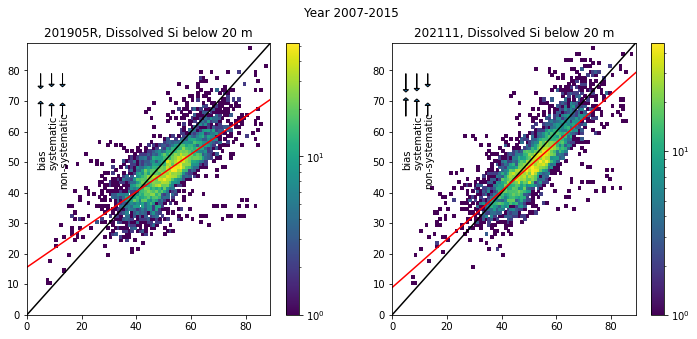

In [58]:
alltogether = plot_allyears(2015)
alltogether.style.format(myformat).apply(highlight_max_min)

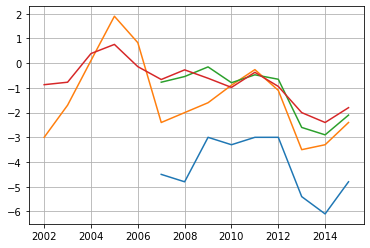

In [60]:
bias_Si_201905 = np.array([-4.5, -4.8, -3, -3.3, -3, -3, -5.4, -6.1, -4.8])
years_201905 = range(2007, 2016)
bias_Si_202111 = np.array([-3, -1.7, 0.11, 1.9, 0.83, -2.4, -2, -1.6, -0.89, -0.26, -1.1, -3.5, -3.3,
                          -2.4])
years_202111 = range(2002, 2016)
bias_N_201905 = np.array([-0.77, -0.54, -0.15, -0.79, -0.47, -0.65, -2.6, -2.9, -2.1])
bias_N_202111 = np.array([-0.87, -0.77, 0.39, 0.76, -0.14, -0.66, -0.27, -0.61, -0.98, -0.37, -0.94, 
                          -2.0, -2.4, -1.8])

plt.plot(years_201905, bias_Si_201905)
plt.plot(years_202111, bias_Si_202111);
plt.plot(years_201905, bias_N_201905);
plt.plot(years_202111, bias_N_202111);
plt.grid();

In [26]:
pieces = ('/data/sallen/results/MEOPAR/202111/ObsModel_202111_bot_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psf_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pug_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_hplc_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_bot_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pug_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_hplc_20160101_20161231.csv'
         )

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
modv202111,1791,-1.6,3.0,0.12,0.27,5.4,2.0,2.3,0.24


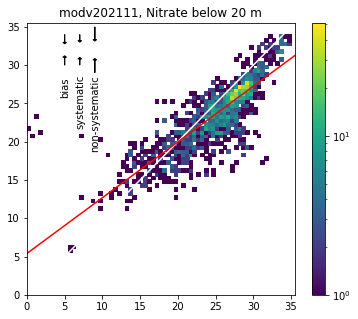

In [27]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modv202111 = plot_and_stats(temp1, 'modv202111', idepth, jdepth)
modv202111.style.format(myformat)

In [31]:
alltogether = pd.concat([d201812, d201905, 
                         dCp2, modCp3, #Dagain, DnoC, DlowR, 
                         modF, #modH, 
                         modGp1, modGp2,
                        modv202111], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1793,-1.9,3.6,0.14,0.069,-0.11,1.9,3.1,-0.3
H201905,1793,-1.9,3.3,0.14,0.27,5.0,2.3,2.3,0.22
Cp2,1793,-2.4,3.6,0.15,0.19,2.3,2.6,2.6,0.039
Cp3,1789,-2.6,3.7,0.16,0.16,1.4,2.7,2.6,-0.015
F,1791,-2.1,3.4,0.15,0.27,4.7,2.5,2.4,0.2
Gp1,1791,-1.7,3.1,0.13,0.24,4.4,2.0,2.4,0.16
Gp2,1791,-1.7,3.1,0.13,0.25,4.7,2.0,2.4,0.17
modv202111,1791,-1.6,3.0,0.12,0.27,5.4,2.0,2.3,0.24


**Conclusion** Gp1 has the best nitrate!  Gp2 very very similar. Fuzz with low model values and obs between 25 and 30 is Puget.

## Question 1: Is the inclusion of Puget Sound why the nitrate is so underpredicted?

In [28]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
#         '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,2429,-1.6,2.6,0.11,0.25,5.0,1.9,1.8,0.26


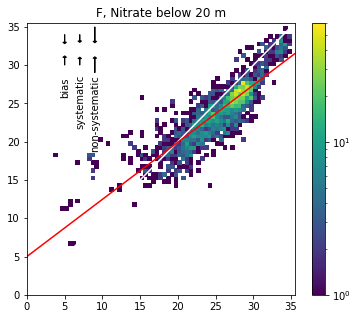

In [29]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modF = plot_and_stats(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

It makes it worse, but the maximum number of points (yellow patch) is not Puget Sound.

## Question 2: Is the bias improving or getting worse in time?

In [34]:
#temp1.set_index('dtUTC', inplace=True)
temp1.index = pd.to_datetime(temp1.index)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F15,392,-2.3,3.0,0.22,0.29,5.4,2.5,1.6,0.23


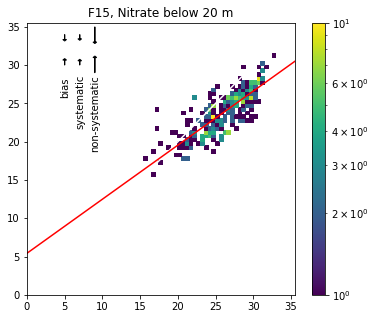

In [38]:
modF15 = plot_and_stats(temp1[temp1.index < dt.datetime(2016, 1, 1)], 'F15', idepth, jdepth)
modF15.style.format(myformat)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F16,1072,-1.7,2.5,0.096,0.16,2.7,1.8,1.7,0.14


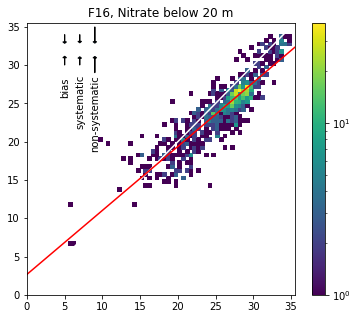

In [40]:
modF16 = plot_and_stats(temp1[(temp1.index >= dt.datetime(2016, 1, 1)) & (temp1.index < dt.datetime(2017, 1, 1))], 'F16', idepth, jdepth)
modF16.style.format(myformat)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F17,965,-1.2,2.7,0.1,0.31,6.7,1.9,1.9,0.36


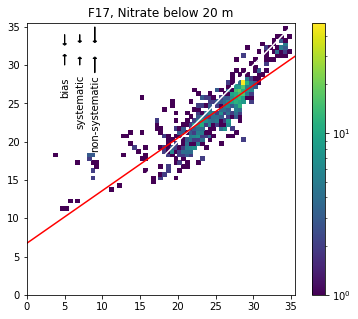

In [41]:
modF17 = plot_and_stats(temp1[temp1.index >= dt.datetime(2017, 1, 1)], 'F17', idepth, jdepth)
modF17.style.format(myformat)

Bias is improving in time.